In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras import regularizers
from tensorflow.keras.applications import VGG16, MobileNetV2
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-04-06 08:08:04.345445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/MyDrive/Edge AI Fall detection/Roboflow/Unwanted Removed.zip" -d "/content/Edge AI Fall detection/"


Streaming output truncated to the last 5000 lines.
  inflating: /content/Edge AI Fall detection/Unwanted Removed/labels/val/non-fall04987.txt  
  inflating: /content/Edge AI Fall detection/__MACOSX/Unwanted Removed/labels/val/._non-fall04987.txt  
  inflating: /content/Edge AI Fall detection/Unwanted Removed/labels/val/non-fall15134.txt  
  inflating: /content/Edge AI Fall detection/__MACOSX/Unwanted Removed/labels/val/._non-fall15134.txt  
  inflating: /content/Edge AI Fall detection/Unwanted Removed/labels/val/fall00130.txt  
  inflating: /content/Edge AI Fall detection/__MACOSX/Unwanted Removed/labels/val/._fall00130.txt  
  inflating: /content/Edge AI Fall detection/Unwanted Removed/labels/val/non-fall07524.txt  
  inflating: /content/Edge AI Fall detection/__MACOSX/Unwanted Removed/labels/val/._non-fall07524.txt  
  inflating: /content/Edge AI Fall detection/Unwanted Removed/labels/val/non-fall03742.txt  
  inflating: /content/Edge AI Fall detection/__MACOSX/Unwanted Removed/label

In [22]:
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:

BASE_DIR = "/content/Edge AI Fall detection/Unwanted Removed"

def data_generator(split='train', pref_size=(128, 128), batch_size=32, augment=False):
    """
    Generator that yields batches of cropped images and class labels.

    Assumes folder structure:
      BASE_DIR/images/<split>/
      BASE_DIR/labels/<split>/

    For each image file, the generator reads the corresponding label file.
    For simplicity, it processes only the first bounding box per file.
    """
    img_dir = os.path.join(BASE_DIR, 'images', split)
    label_dir = os.path.join(BASE_DIR, 'labels', split)

    img_files = sorted(os.listdir(img_dir))
    label_files = sorted(os.listdir(label_dir))

    num_samples = len(img_files)

    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for offset in range(0, num_samples, batch_size):
            batch_imgs = []
            batch_labels = []
            batch_indices = indices[offset:offset+batch_size]

            for idx in batch_indices:
                img_file = img_files[idx]
                label_file = label_files[idx]

                img_path = os.path.join(img_dir, img_file)
                img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
                image_height, image_width, _ = img.shape


                label_path = os.path.join(label_dir, label_file)
                with open(label_path, 'r', encoding='utf-8', errors='ignore') as f:
                    lines = f.readlines()
                if len(lines) == 0:
                    continue

                line = lines[0]
                parts = line.split()
                if len(parts) < 5:
                    print(f"Warning: {label_file} does not have enough values: {line}")
                    continue
                class_label = int(parts[0])
                if len(parts) == 5:
                    x_center, y_center, width, height = map(float, parts[1:5])
                    xmin = int(x_center * image_width - (width * image_width) / 2)
                    ymin = int(y_center * image_height - (height * image_height) / 2)
                    crop_width = int(width * image_width)
                    crop_height = int(height * image_height)
                else:
                    coords = list(map(float, parts[1:]))
                    xs = [x * image_width for x in coords[0::2]]
                    ys = [y * image_height for y in coords[1::2]]
                    xmin, ymin = int(min(xs)), int(min(ys))
                    xmax, ymax = int(max(xs)), int(max(ys))
                    crop_width, crop_height = xmax - xmin, ymax - ymin

                x_start, y_start = max(0, xmin), max(0, ymin)
                x_end, y_end = min(image_width, xmin + crop_width), min(image_height, ymin + crop_height)

                cropped = img[y_start:y_end, x_start:x_end]
                if cropped.size == 0:
                    print(f"Warning: empty crop for {img_file} with box {line}")
                    continue
                try:
                    cropped_resized = cv2.resize(cropped, pref_size)
                except Exception as e:
                    print(f"Error resizing image {img_file}: {e}")
                    continue
                if augment:
                    cropped_resized = image_datagen.random_transform(cropped_resized)

                batch_imgs.append(cropped_resized)
                batch_labels.append(class_label)

            if batch_imgs:  
                X_batch = np.array(batch_imgs, dtype=np.float32) / 255.0
                y_batch = np.array(batch_labels)
                yield X_batch, y_batch

In [ ]:
def count_samples(split='train'):
    img_dir = os.path.join(BASE_DIR, 'images', split)
    return len(os.listdir(img_dir))

BATCH_SIZE = 32
train_samples = count_samples('train')
val_samples   = count_samples('val')
test_samples  = count_samples('test')

steps_per_epoch = int(np.ceil(train_samples / BATCH_SIZE))
val_steps       = int(np.ceil(val_samples / BATCH_SIZE))
test_steps      = int(np.ceil(test_samples / BATCH_SIZE))

print(f"Train samples: {train_samples}, Steps per epoch: {steps_per_epoch}")
print(f"Validation samples: {val_samples}, Validation steps: {val_steps}")
print(f"Test samples: {test_samples}, Test steps: {test_steps}")


Train samples: 23756, Steps per epoch: 743
Validation samples: 6638, Validation steps: 208
Test samples: 3340, Test steps: 105


In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator('train', batch_size=BATCH_SIZE, augment=True),
    output_types=(tf.float32, tf.int32),
    output_shapes=([None, 128, 128, 3], [None])
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator('val', batch_size=BATCH_SIZE, augment=False),
    output_types=(tf.float32, tf.int32),
    output_shapes=([None, 128, 128, 3], [None])
).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator('test', batch_size=BATCH_SIZE, augment=False),
    output_types=(tf.float32, tf.int32),
    output_shapes=([None, 128, 128, 3], [None])
).prefetch(tf.data.AUTOTUNE)

In [ ]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True
    
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), 
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 1,370,306 (5.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=[early_stop]
)

Epoch 1/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 584s 767ms/step - accuracy: 0.6603 - loss: 0.9228 - val_accuracy: 0.8083 - val_loss: 0.6945
Epoch 2/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 659s 887ms/step - accuracy: 0.8536 - loss: 0.5732 - val_accuracy: 0.8867 - val_loss: 0.5126
Epoch 3/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 561s 755ms/step - accuracy: 0.8892 - loss: 0.5048 - val_accuracy: 0.9097 - val_loss: 0.4586
Epoch 4/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 529s 712ms/step - accuracy: 0.9017 - loss: 0.4733 - val_accuracy: 0.9313 - val_loss: 0.4025
Epoch 5/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 568s 765ms/step - accuracy: 0.9123 - loss: 0.4468 - val_accuracy: 0.9358 - val_loss: 0.3871
Epoch 6/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 558s 751ms/step - accuracy: 0.9238 - loss: 0.4153 - val_accuracy: 0.9393 - val_loss: 0.3760
Epoch 7/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 464s 624ms/step - accuracy: 0.9267 - loss: 0.4081 - val_accuracy: 0.9417 - val_loss: 0.3710
Epoch 8/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 444s 598ms/step - accuracy: 0.9311 -

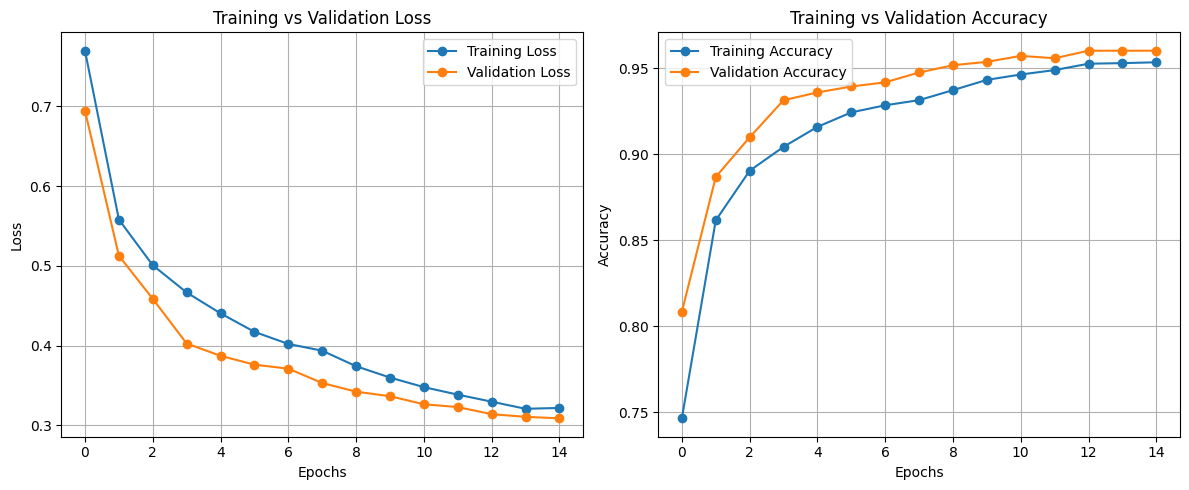

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss", marker='o')
plt.plot(val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Training Accuracy", marker='o')
plt.plot(val_acc, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
model.save('data-augmented.h5')


In [41]:
model = tf.keras.models.load_model('/Users/Muaadh Nazly/Muaadh/IIT/Year 3 AI & DS/Semester 2/CM 3603 Edge AI/CW/Implementation/roboflow/fresh25.h5')

In [40]:
# Evaluate on the test set after training
test_loss, test_accuracy = model.evaluate(test_dataset, steps=test_steps)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


105/105 ━━━━━━━━━━━━━━━━━━━━ 66s 622ms/step - accuracy: 0.5104 - loss: 1.0431
Test Loss: 1.0460, Test Accuracy: 0.5031


In [ ]:
# -------------------------------
# Load YOLOv5 model (detection)
# -------------------------------
import torch
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
yolo_model.classes = [0]  

In [ ]:
model = tf.keras.models.load_model('data-augmented.h5.h5')  
pref_size = (128, 128)

FALL_THRESHOLD = 0.6  

def classify_crop_h5(cropped_img, threshold=FALL_THRESHOLD):
    """
    Preprocess a cropped image and run classification using the Keras model.
    Returns the predicted class and the raw model output.
    Uses a custom threshold for the fall class (index 0).
    """

    cropped_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(cropped_rgb, pref_size)
    normalized = resized.astype(np.float32) / 255.0
    input_data = np.expand_dims(normalized, axis=0)
    
    preds = model.predict(input_data)  
    
    if preds[0, 0] > threshold:
        pred = 0
    else:
        pred = 1

    
    return pred, preds

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

print("Starting real-time fall detection with .h5 model. Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame. Exiting...")
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(frame_rgb)
    results = yolo_model(pil_img, size=640)  
    df = results.pandas().xyxy[0]
    fall_detected = False
    YOLO_CONFIDENCE_THRESHOLD = 0.4
    for idx, row in df.iterrows():
        if row['confidence'] > YOLO_CONFIDENCE_THRESHOLD:
            x1 = int(row['xmin'])
            y1 = int(row['ymin'])
            x2 = int(row['xmax'])
            y2 = int(row['ymax'])
            crop = frame[y1:y2, x1:x2]
            if crop.size == 0:
                continue

            pred, raw_output = classify_crop_h5(crop, threshold=FALL_THRESHOLD)
            print(f"Raw output: {raw_output}, Predicted class: {pred}")


            if pred == 0:
                label_text = "Fall Detected"
                fall_detected = True
            else:
                label_text = "Non-Fall"

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label_text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    if fall_detected:
        print("Fall detected in current frame!")

    cv2.imshow("Real-Time Fall Detection (.h5 Model)", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Starting real-time fall detection with .h5 model. Press 'q' to quit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Raw output: [[ 1.8102e-08           1]], Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Raw output: [[ 2.1498e-06           1]], Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Raw output: [[  0.0001125     0.99989]], Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Raw output: [[ 4.9592e-07           1]], Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
Raw output: [[ 1.5599e-07           1]], Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Raw output: [[  3.554e-07           1]], Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Raw output: [[ 1.5641e-09           1]], Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Raw output: [[ 9.5346e-11           1]], Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Raw output: [[  4.775e-10           1]], Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Raw 

KeyboardInterrupt: 